# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from importlib import reload

# Data loading

In [2]:
data = pd.read_csv('loan.csv')
data.shape

(39717, 111)

# Data cleaning

#### 1. Fix columns
###### 1.1 Find all the columns where more than 50% records are empty

In [3]:
colms_with_more_than_half_nulls = data.columns[data.isnull().mean()*100 > 50]
round(data[colms_with_more_than_half_nulls].isnull().mean()*100, 2)

mths_since_last_delinq             64.66
mths_since_last_record             92.99
next_pymnt_d                       97.13
mths_since_last_major_derog       100.00
annual_inc_joint                  100.00
dti_joint                         100.00
verification_status_joint         100.00
tot_coll_amt                      100.00
tot_cur_bal                       100.00
open_acc_6m                       100.00
open_il_6m                        100.00
open_il_12m                       100.00
open_il_24m                       100.00
mths_since_rcnt_il                100.00
total_bal_il                      100.00
il_util                           100.00
open_rv_12m                       100.00
open_rv_24m                       100.00
max_bal_bc                        100.00
all_util                          100.00
total_rev_hi_lim                  100.00
inq_fi                            100.00
total_cu_tl                       100.00
inq_last_12m                      100.00
acc_open_past_24

##### 1.2 Delete all the columns where more than 50% records are empty

In [4]:
data = data.drop(columns = colms_with_more_than_half_nulls, axis = 1)

In [5]:
data.shape

(39717, 54)

##### 1.3 Delete Unnecessary columns

In [6]:
descriptive_cols = ['desc', 'url', 'emp_title', 'title', 'id', 'member_id']
data = data.drop(columns = descriptive_cols, axis = 1)

single_val_cols = ['application_type', 'pymnt_plan', 'initial_list_status', 'tax_liens', 'chargeoff_within_12_mths', 
                   'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'delinq_amnt']
data = data.drop(columns = single_val_cols, axis = 1)

redundant_cols = ['zip_code']
data = data.drop(columns=redundant_cols, axis = 1)

In [7]:
data.shape

(39717, 38)

#### 2. Fix rows
##### 2.1 Find number of missing values rows in the null columns

In [8]:
data[data.columns[data.isnull().any()]].isnull().sum()

emp_length              1075
revol_util                50
last_pymnt_d              71
last_credit_pull_d         2
pub_rec_bankruptcies     697
dtype: int64

#### *2.2 Delete all the rows with null values*

In [9]:
data = data[(~data['revol_util'].isnull()) & (~data['last_pymnt_d'].isnull()) & (~data['emp_length'].isnull()) & 
            (~data['last_credit_pull_d'].isnull()) & (~data['pub_rec_bankruptcies'].isnull())]

In [10]:
data.shape

(37835, 38)

# Univariate analysis on categorical variables

#### 1. Analysis on Loan Status
Below pie chart shows that most of the loan applications status are **'Fully Paid'** and only 13.75% applications are **'Charged Off'**.

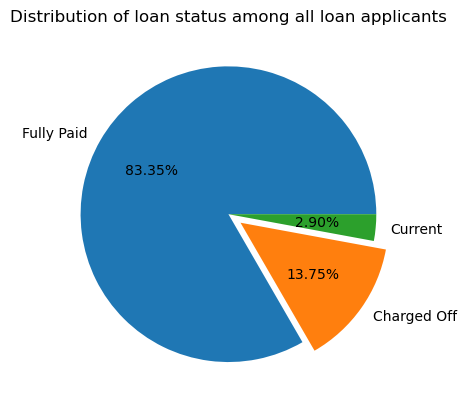

In [11]:
plt = reload(plt)
plt.pie(x = data['loan_status'].value_counts()*100 / len(data['loan_status']), autopct='%.2f%%', 
        labels=data['loan_status'].value_counts().index, explode = [0, 0.1, 0])
plt.title('Distribution of loan status among all loan applicants')
plt.show()

#### 2. Analysis on Loan Purpose
Below barchart shows that most of the loan applicants are **debt consolidators**.

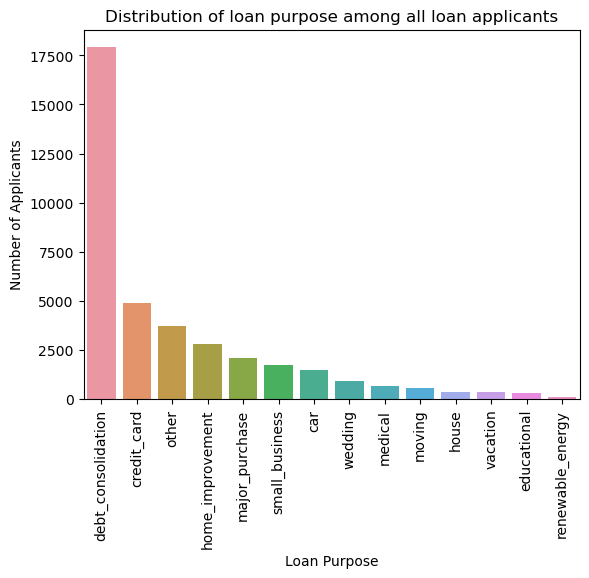

In [12]:
plt = reload(plt)
sns.barplot(y = data['purpose'].value_counts(), x = data['purpose'].value_counts().index)
plt.xticks(rotation = 90)
plt.title('Distribution of loan purpose among all loan applicants')
plt.xlabel('Loan Purpose')
plt.ylabel('Number of Applicants')
plt.show()

#### 3. Analysis on Loan Term
Below pie chart shows that most of the applicants(**72.68%**) choose **36 months** term plan to repay the loan.

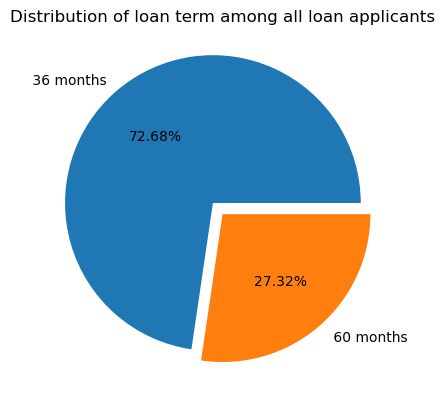

In [13]:
plt = reload(plt)
plt.pie(x = data['term'].value_counts()*100 / len(data['term']), autopct='%.2f%%', labels=data['term'].value_counts().index, 
        explode = [0.1, 0])
plt.title('Distribution of loan term among all loan applicants')
plt.show()

#### 4. Analysis on Employment Length
Below pie chart shows that the **majority** of the loan appliers having **10+ years** of service length.

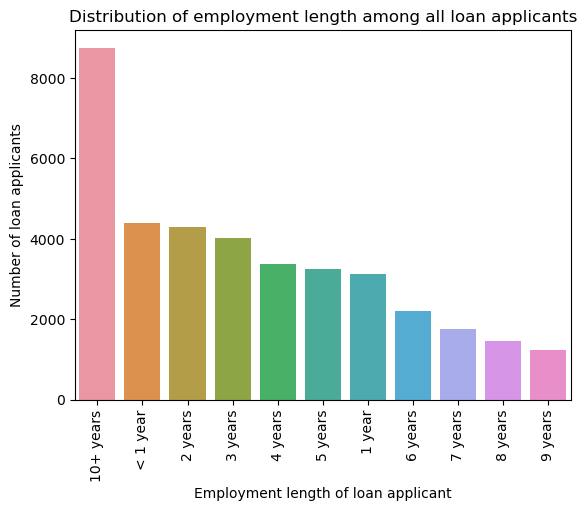

In [14]:
plt = reload(plt)
sns.barplot(x = data['emp_length'].value_counts().index, y = data['emp_length'].value_counts())
plt.xticks(rotation = 90)
plt.xlabel('Employment length of loan applicant')
plt.ylabel('Number of loan applicants')
plt.title('Distribution of employment length among all loan applicants')
plt.show()

#### 5. Analysis on House Ownership
Below barchart shows that **majority** of the loan applicants are either resides in **rented house** or they **mortgage their houses**.

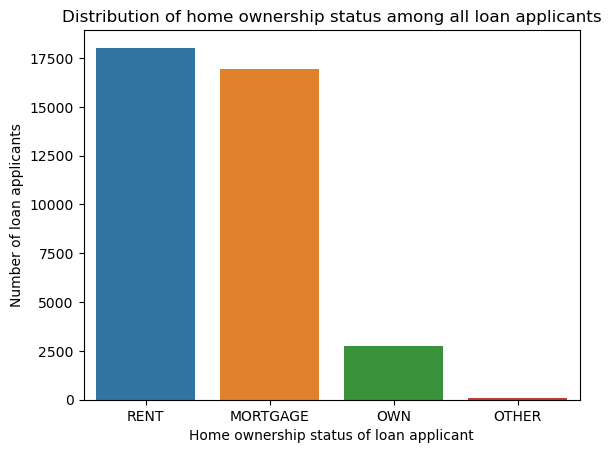

In [15]:
plt = reload(plt)
sns.barplot(x = data['home_ownership'].value_counts().index, y = data['home_ownership'].value_counts())
plt.xlabel('Home ownership status of loan applicant')
plt.ylabel('Number of loan applicants')
plt.title('Distribution of home ownership status among all loan applicants')
plt.show()

#### 6. Analysis on Verification Status
Below pie chart shows that **41.60%** people's income are **not verified** by LC.

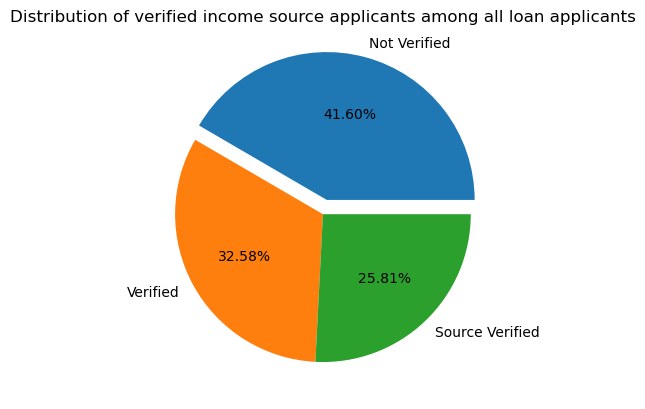

In [16]:
plt = reload(plt)
plt.pie(x = data['verification_status'].value_counts()*100 / len(data['verification_status']), autopct='%.2f%%', 
        labels=data['verification_status'].value_counts().index, explode = [0.1, 0, 0])
plt.title('Distribution of verified income source applicants among all loan applicants')
plt.show()

#### 7. Analysis on State
Below bar chart shows that **state CA** has **highest** loan applications.

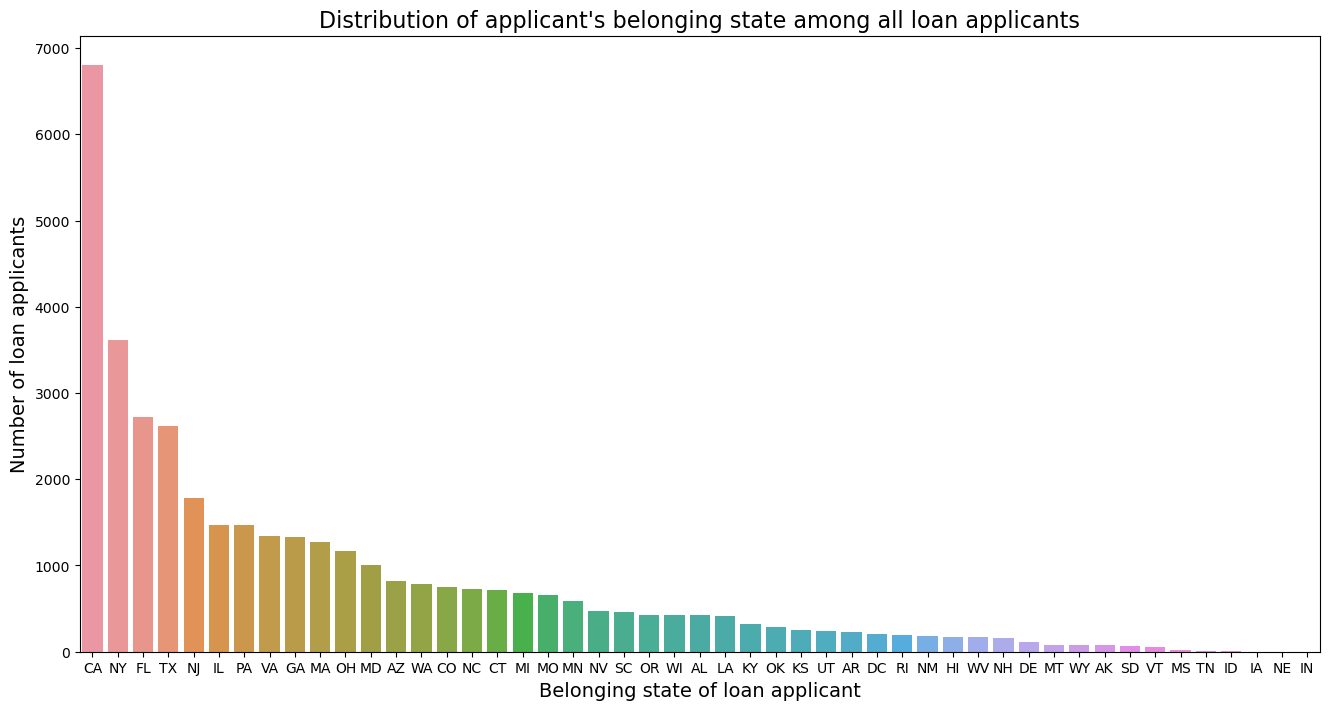

In [17]:
plt = reload(plt)
plt.figure(figsize = (16, 8))
sns.barplot(x = data['addr_state'].value_counts().index, y = data['addr_state'].value_counts())
plt.xlabel('Belonging state of loan applicant', fontsize=14)
plt.ylabel('Number of loan applicants', fontsize=14)
plt.title("Distribution of applicant's belonging state among all loan applicants", fontsize=16)
plt.show()

#### 8. Analysis on Grade
LC assigns **A and B grade** to mostly applicants.

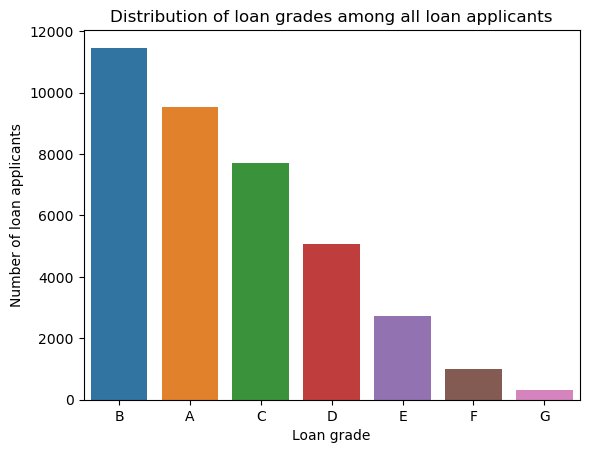

In [18]:
plt = reload(plt)
sns.barplot(x = data['grade'].value_counts().index, y = data['grade'].value_counts())
plt.xlabel('Loan grade')
plt.ylabel('Number of loan applicants')
plt.title("Distribution of loan grades among all loan applicants")
plt.show()

#### 9. Analysis on Sub Grade
LC assigns **B3, A4 and A5 grade** to mostly applicants.

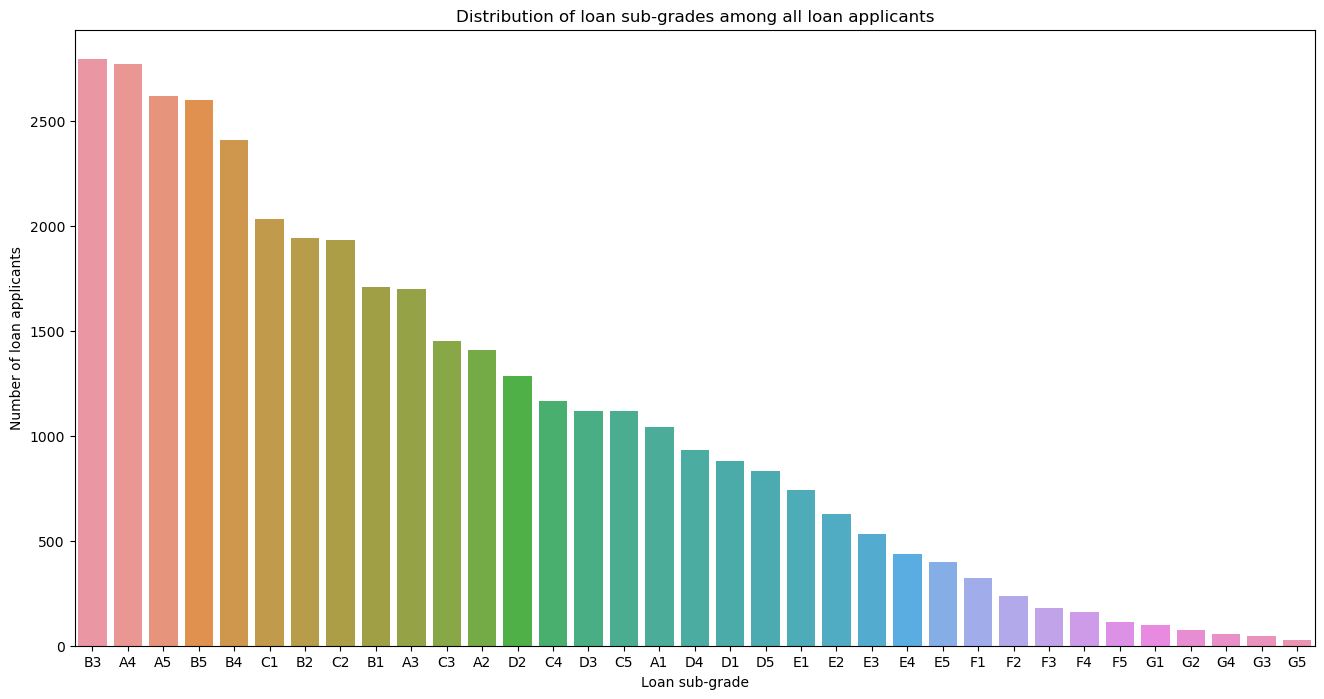

In [19]:
plt = reload(plt)
plt.figure(figsize = (16,8))
sns.barplot(x = data['sub_grade'].value_counts().index, y = data['sub_grade'].value_counts())
plt.xlabel('Loan sub-grade')
plt.ylabel('Number of loan applicants')
plt.title("Distribution of loan sub-grades among all loan applicants")
plt.show()

#### 10. Analysis on Public Record Bankruptcies
Very few applicants are officially bankrupt.

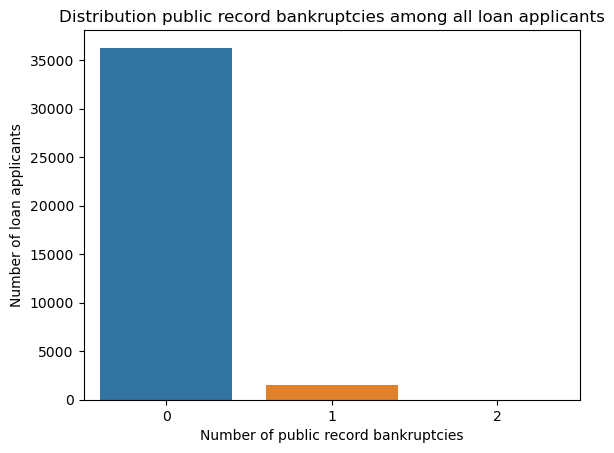

In [20]:
plt = reload(plt)
data['pub_rec_bankruptcies'] = data['pub_rec_bankruptcies'].astype('int32')
sns.barplot(x = data['pub_rec_bankruptcies'].value_counts().index, y = data['pub_rec_bankruptcies'].value_counts())
plt.xlabel('Number of public record bankruptcies')
plt.ylabel('Number of loan applicants')
plt.title("Distribution public record bankruptcies among all loan applicants")
plt.show()